Using TensorFlow backend.


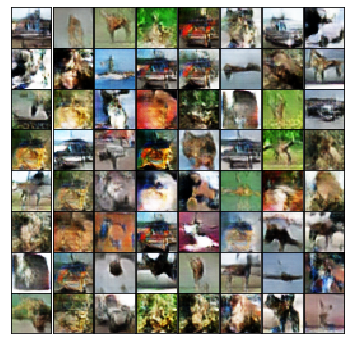

FID score for DCGAN with BCE loss :  90.98191240101764


In [1]:
                                  #####  DCGAN  #####
    
from __future__ import print_function, division
import numpy as np
from numpy import asarray
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy.random import shuffle
from numpy.random import randint
from numpy.random import randn
from numpy.random import random
from tqdm import tqdm

from keras.callbacks import TensorBoard
from scipy.linalg import sqrtm
from skimage.transform import resize
from matplotlib import pyplot as plt
%matplotlib inline

import time
import sys
import os
import keras
import keras.backend as K
import tensorflow as tf

# cifar10 dataset is available in keras
from keras.datasets import cifar10
from keras.preprocessing import image

# Models -> Layers -> Initializers -> Optimizers -> Utility function
from keras.models import Model,Sequential,load_model
from keras.layers import Input,Dense,LeakyReLU,BatchNormalization,Conv2D
from keras.layers import Conv2DTranspose,Reshape,Dropout,Flatten,Activation,UpSampling2D,Concatenate
from Spectral_Normalization import SelfAttention 
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from keras.utils import plot_model, np_utils
from contextlib import redirect_stdout  # for writing model.summary into a text file
from keras.utils import np_utils, to_categorical
from Spectral_Normalization import ConvSN2D

# Inceptionv3 model for FID calculation
from keras.applications.inception_v3 import InceptionV3, preprocess_input
tf.logging.set_verbosity(tf.logging.ERROR)  # suppressing warning messages


# Loading Data
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()


# The range of pixel values should be in [-1,1] as 'tanh' activation is used in generator model
def preprocess(x):
    return (x/255)*2-1
  
X_train = preprocess(X_train)
X_test  = preprocess(X_test)

tf.logging.set_verbosity(tf.logging.ERROR)
import warnings
warnings.filterwarnings('ignore')


# load the images into memory
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()


def create_D(alpha, init_sd):
  
    '''
       alpha   :  "LeakyRelu" activation function
       init_sd :   SD of the Gaussian Distribution for kernel initialization

    '''
    
    D = Sequential(name='Discriminator')
    
    init = RandomNormal(stddev=init_sd) # zero-centered Gaussian distribution with a standard deviation of 0.02.
  
    ## Downsample Using Strided Convolutions ##
    
    # step 01: Downsampling : 32x32x3 --> 16x16x64
    D.add(Conv2D(64, (5,5), strides=2, padding='same', kernel_initializer=init, input_shape=(32,32,3)))
    D.add(LeakyReLU(alpha))

    # step 02: Downsampling : 16x16x64 --> 8x8x128
    D.add(Conv2D(128, (5,5), strides=2, padding='same'))
    D.add(BatchNormalization(momentum=0.9))
    D.add(LeakyReLU(alpha))

    # step 03: Downsampling : 8x8x128 --> 4x4x256
    D.add(Conv2D(256,(5,5), strides=2, padding='same'))
    D.add(BatchNormalization(momentum=0.9))
    D.add(LeakyReLU(alpha))

    # step 04: Downsampling : 4x4x256 --> 2x2x512
    D.add(Conv2D(512,(5,5), strides=2, padding='same', kernel_initializer=init))
    D.add(BatchNormalization(momentum=0.9))
    D.add(LeakyReLU(alpha))

    # Final Layer : Fully Connected Layer (classifier) , 2x2x512 (2048) ---> 1
    D.add(Flatten())
    D.add(Dropout(0.4))
    D.add(Dense(1,activation='sigmoid'))  
    
    return D



def create_G(alpha, init_sd):
  
    ''' alpha   :  "LeakyRelu" activation function
        init_sd :   SD of the Gaussian Distribution for kernel initialization
    '''
    
    G    = Sequential(name='Generator')
    
    init = RandomNormal(stddev=init_sd)
   
    # step 01:  512 activation maps of 2x2 
    G.add(Dense(512*2*2, input_shape=(100,), kernel_initializer=init)) # FC layer
    G.add(Reshape((2, 2, 512)))
    G.add(BatchNormalization(momentum=0.9))
    G.add(LeakyReLU(alpha))

    # step 02: upsampling to 4x4: [256 activation maps of 4x4] 
    G.add(Conv2DTranspose(256, (5,5), strides=2, padding='same', kernel_initializer=init))
    G.add(BatchNormalization(momentum=0.9))
    G.add(LeakyReLU(alpha))


    # step 03: upsampling to 8x8: [128 activation maps of 8x8] 
    G.add(Conv2DTranspose(128,(5,5),strides=2, padding='same', kernel_initializer=init))
    G.add(BatchNormalization(momentum=0.9))
    G.add(LeakyReLU(alpha))
    
    # step 04: upsampling to 16x16 [64 activation maps of 16x16]
    G.add(Conv2DTranspose(64,(5,5),strides=2, padding='same', kernel_initializer=init))
    G.add(BatchNormalization(momentum=0.9))
    G.add(LeakyReLU(alpha))
    
    # output layer : 'tanh' activation so domain of pixel value is [-1,1]
    
    G.add(Conv2DTranspose(3,(5,5), strides=2, padding='same', kernel_initializer=init, activation='tanh'))  
    
    return G


def create_DCGAN(g_learning_rate, g_beta_1, d_learning_rate, d_beta_1, leaky_alpha, init_std):
  
    # generator
    G = create_G(leaky_alpha, init_std)


    # discriminator
    D = create_D(leaky_alpha, init_std)
    D.compile(optimizer=Adam(lr=d_learning_rate, beta_1=d_beta_1), loss='binary_crossentropy',metrics=['binary_accuracy'])
    
    # GAN
    gan = Sequential([G,D])
    gan.compile(optimizer=Adam(lr=g_learning_rate, beta_1=g_beta_1), loss='binary_crossentropy',metrics=['binary_accuracy'])
    
    return gan, G, D


# Gaussian Latent Space 
def make_latent_samples(n_samples, sample_size):  # n_samples corresponds to batch size in training
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))
  

def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable
        
        
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])
  
'''
Label Smoothing : From Soumith Chintala’s GAN Hacks 
Ref : https://www.youtube.com/watch?v=X1mUN6dD8uE

'''
# smoothing Real images to [0.9, 1.0]
def smooth_positive_labels(y):
    return y - 0.1 + (random(y.shape)*0.1)


# smoothing fake images to [0.0, 0.1]
def smooth_negative_labels(y):
    return y + random(y.shape) * 0.1


def show_images(epoch, generated_images):  
    '''
     This function expects 'atleast 64' generated images by GAN
    '''
    fig = plt.figure(figsize=(8, 8))
    
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.001, hspace=0.001)
    
    for i in range(64):
        ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[])
        ax.imshow(np.uint8(((generated_images[i]+1)/2)*255), cmap='gray')
        
    plt.savefig('GANimage_iteration_{:05d}.png'.format(epoch))
    plt.close()
    
    
def show_final_iamges(generated_images):  
    '''
     This function expects 'atleast 64' generated images by GAN
    '''
    fig = plt.figure(figsize=(6, 6))
    
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.001, hspace=0.001)
    
    for i in range(64):
      
        ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[])
        ax.imshow(np.uint8(((generated_images[i]+1)/2)*255), cmap='gray')
        
    plt.show()
    

# GIVEN BY TA
def plot_data(x,ax):
    ax.imshow((x+1)/2, cmap='gray') # to rescale from -1,1 to 0,

def plotGeneratedImages(generator,epoch,examples=100, dim=(1, 1), figsize=(2, 2)):
    n_classes = 10
    z = np.repeat(np.random.uniform(-1, 1, (10, 100)),10,axis=0)
    
    latent_samples = make_latent_samples(100, 100)
            
    random_labels  = to_categorical(np.random.randint(0, 10, 100).reshape(-1, 1), num_classes=10)  # fake label

    generatedImages   = generator.predict_on_batch([latent_samples, random_labels])
    
    
    fig = plt.figure(figsize=(5,5))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.01, wspace=0.01)
    
    for i in range(examples):
        ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
        plot_data(generatedImages[i], ax)
    
    plt.savefig('GAN_random_{:05d}.png'.format(epoch))
    plt.close()
    
def plot_images(x, batch_size = 64):
    fig = plt.figure(figsize=(6,6))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.01, wspace=0.01)

    for i in range(batch_size):
        ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
        plot_data(x[i], ax)
        
        
                                ##### FID Calculation ######
        
# Reference from where I take help to implement FID.
# https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/?fbclid=IwAR0GAOPTbzgCHJ3ypbO9_JUCipGKoZHSh3S_KUu3EhysE4Tog1OfZF90_0o
                                

def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        new_image = resize(image, new_shape)
        images_list.append(new_image)
    return asarray(images_list)

def calculate_fid(model, act1, images2):
   
    act2 = model.predict(images2)

    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    
    ssdiff = np.sum((mu1 - mu2)**2.0)
    
    covmean = sqrtm(sigma1.dot(sigma2))
   
    if iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)  # Equation for FID score calculation
    
    return fid


   ###  Preparing  test images for 'inceptionv3' model  ####


# Upscale batchwsie to avoid ram exploding
# Remove preprocess() function of inceptionV3 model

s = time.time()

upscale_shape = (299 ,299, 3)
inception = InceptionV3(include_top=False, pooling='avg', input_shape = upscale_shape)

if not os.path.exists('test_imgs_fid.npy'):
    test_imgs_fid = []
    batch = 100
    for i in tqdm(range(len(X_test)//batch)):
        temp_1 = X_test[i*batch:(i+1)*batch]
        temp_2 = scale_images(temp_1.astype('float32'), upscale_shape)
        test_imgs_fid.append(inception.predict(temp_2))

    test_imgs_fid = (np.asarray(test_imgs_fid))
    test_imgs_fid = test_imgs_fid.reshape(-1, 2048)
  
    np.save('test_imgs_fid', test_imgs_fid)
else:
    test_imgs_fid =np.load('test_imgs_fid.npy')
    
    

                                    ##### TRAINING #####
        
    
def train_DCGAN(g_learning_rate,    # learning rate for the generator
                g_beta_1,           # the exponential decay rate for the 1st moment estimates in Adam optimizer
                d_learning_rate,    # learning rate for the discriminator
                d_beta_1,           # the exponential decay rate for the 1st moment estimates in Adam optimizer
                leaky_alpha,
                init_std):

    best_fid_score = float(next(open('best_fid.txt')))

    # Training specific Hyperparameter
    
    max_iters = 175000

    smooth= 0.05        # label smooting to avoid overfitting problem in discriminator model
    batch_size = 64     # train batch size
    eval_size  = 64     # evaluate size

    
    # Get the previous iteration counts if the models was trained before
    prev_iter = 0
    
    if os.path.exists('fid_scores.txt'):
        prev_iter = sum(1 for line in open('fid_scores.txt'))-1
        
    print('Previous iteration count :',prev_iter)
    

    # labels for the batch size and the test size
    y_train_real, y_train_fake = make_labels(batch_size)
    y_eval_real,  y_eval_fake  = make_labels(eval_size)
    
    
    # create a GAN, a generator and a discriminator or load the previously trained models
    if os.path.exists('best_generator.h5'):
        generator     = load_model('best_generator.h5')
        print("Loaded generator")
        
        discriminator = load_model('best_discriminator.h5')
        print("Loaded discriminator")
        
        gan           = load_model('best_gan.h5')
        print("Loaded GAN")
      
    else:
        gan, generator, discriminator = create_DCGAN(g_learning_rate, g_beta_1, d_learning_rate, d_beta_1, leaky_alpha, init_std)
        print("Created new Gan, Generator and Discriminator")
      
      
    start_time = time.time()
    
    
    for iters in range(0, max_iters):
     
        # TRAIN - DISCRIMINATOR
        
        print("Iteration : ", iters)

        discriminator.trainable = True

        # Real samples
        X_batch_real = X_train[np.random.choice(X_train.shape[0], batch_size , replace = True), :] 
        

        # Fake Samples
        latent_samples = make_latent_samples(batch_size, 100)
        X_batch_fake   = generator.predict_on_batch(latent_samples)
        

        # Train the discriminator to detect real and fake images
        
        discriminator.train_on_batch(X_batch_real, smooth_positive_labels(y_train_real))
        discriminator.train_on_batch(X_batch_fake, y_train_fake)


      
        # TRAIN - GENERATOR
              
        discriminator.trainable = False # make_trainable(discriminator, False)
        
        gan.train_on_batch(latent_samples, y_train_real)
        

        # Loss and FID calculation after every 1000 iterations
        
        if (iters + 1) % 1000 == 0:
            
            # Validation Losses
            latent_samples = make_latent_samples(eval_size, 100)
            gan_images     = generator.predict_on_batch(latent_samples)

            X_eval_real    = X_test[np.random.choice(len(X_test), eval_size, replace = True), :]

            d_loss_real  = discriminator.test_on_batch(X_eval_real, y_eval_real)
            d_loss_fake  = discriminator.test_on_batch(gan_images, y_eval_fake)

            g_loss_batch = gan.test_on_batch(latent_samples, y_eval_real)


            with open("losses.txt", "a") as f:
                total = 0.5 * ( round(d_loss_real[0],12) + round(d_loss_fake[0],12) )
                f.write( str(round(d_loss_real[0],12)) + ' ' + str(round(d_loss_fake[0],12)) +' ' + str(total) + ' ' + str( round(g_loss_batch[0],12) ) )
                f.write('\n')
       
                

            # FID calculation
            
            latent_samples = make_latent_samples(1000, 100)
            gan_images     = generator.predict_on_batch(latent_samples)

            gan_images    = scale_images(gan_images.astype('float32'), upscale_shape)
            
            test_img_act  = test_imgs_fid[np.random.choice(test_imgs_fid.shape[0], 1000, replace = True), :]  

            cur_fid_score = calculate_fid(inception, test_img_act, gan_images)

            with open("fid_scores.txt", "a") as f:
                f.write(str(iters+1+prev_iter)+' '+str(round(cur_fid_score,4)))
                f.write('\n')
                
            
            
            # save image with label
            show_images(iters+prev_iter, gan_images)
            plotGeneratedImages(generator, iters+prev_iter)
 

            ## CHECKPOINT FOR SAVING MODEL ## 
            
            if cur_fid_score < best_fid_score:

                best_fid_score = cur_fid_score

                with open('best_fid.txt', 'w') as f:
                    f.write(str(cur_fid_score))

                # Save the Generator 
                if os.path.exists('best_generator.h5'):
                    os.remove('best_generator.h5')
                    
                generator.save('best_generator.h5')
            
                # Save the Discriminator
                if os.path.exists("best_discriminator.h5"):
                    os.remove("best_discriminator.h5")
                    
                discriminator.save('best_discriminator.h5')

            
                # Save the combined GAN
                if os.path.exists("best_gan.h5"):
                    os.remove("best_gan.h5")
                    
                gan.save('best_gan.h5')
                
            if iters==75000:
                generator.save('seventyFive_generator.h5')
                discriminator.save('seventyFive_discriminator.h5')
                gan.save('seventyFive_gan.h5')
          
          
            if iters==100000:
                generator.save('hundred_generator.h5')
                discriminator.save('hundred_discriminator.h5')
                gan.save('hundred_gan.h5')
          
          
            if iters==150000:
                generator.save('hundred_fifty_generator.h5')
                discriminator.save('hundred_fifty_discriminator.h5')
                gan.save('hundred_fifty_gan.h5')

                
      
    print("Training Time:- %s seconds" % (time.time() - start_time))
        
    return 

#train_DCGAN(g_learning_rate=0.0001,g_beta_1=0.5,d_learning_rate=0.0004,d_beta_1=0.5,leaky_alpha=0.2,init_std=0.02)




# Load best generator model
generator = load_model('best_generator.h5')

# show 64 generated images from the model in a 8 by 8 grid
show_final_iamges(generator.predict(make_latent_samples(64, 100))) 

# Printing FID score

gan_images    = generator.predict(make_latent_samples(1000, 100))
gan_images    = scale_images(gan_images.astype('float32'), upscale_shape)
test_img_act  = test_imgs_fid[np.random.choice(test_imgs_fid.shape[0], 1000, replace = True), :]  

FID = calculate_fid(inception, test_img_act, gan_images)

print("FID score for DCGAN with BCE loss : ", FID)

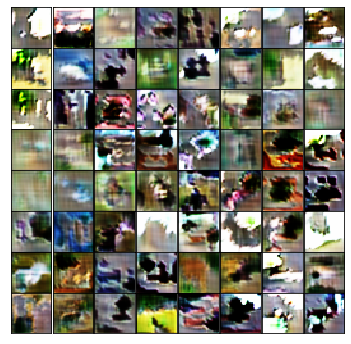

FID score for cWGAN with self attention :  142.0398704890392


In [2]:
   
                                ##### cWGAN with SELF ATTENTION  #####

# Discriminator Model
def create_D(alpha, init_sd):
  
    '''
       alpha   :  "LeakyRelu" activation function
       init_sd :   SD of the Gaussian Distribution for kernel initialization
    '''
    
    init = RandomNormal(stddev=init_sd) # zero-centered Gaussian distribution with a standard deviation of 0.02.
    
    img_shape = X_train[0].shape
    
    img_input = Input(shape=(X_train[0].shape))
    
    labels = Input(shape=(10,))
    
    
    # step 01: Downsampling : 32x32x3 --> 16x16x64
    D = ConvSN2D(64, kernel_size=5, strides=2, padding='same', input_shape=(img_shape), use_bias = False, kernel_initializer=init)(img_input)
    D = LeakyReLU(alpha)(D)
    
    D = SelfAttention(ch=64)(D)
 
    # step 02: Downsampling : 16x16x64 --> 8x8x128
    D = ConvSN2D(128, kernel_size=5, strides=2, padding="same", kernel_initializer=init, use_bias=False)(D)
    D = BatchNormalization(momentum=0.9)(D)
    D = LeakyReLU(alpha)(D)

    # step 03: Downsampling : 8x8x128 --> 4x4x256
    D = ConvSN2D(256, kernel_size=5, strides=2, padding="same", kernel_initializer=init, use_bias=False)(D)
    D = BatchNormalization(momentum=0.9)(D)
    D = LeakyReLU(alpha)(D)

    # step 04: Downsampling : 4x4x256 --> 2x2x512
    D = ConvSN2D(512, kernel_size=5, strides=2, padding="same", kernel_initializer=init, use_bias=False)(D)
    D = BatchNormalization(momentum=0.9)(D)
    D = LeakyReLU(alpha)(D)
    
    
    # Final Layer : Fully Connected Layer (classifier) , 2x2x512 (2048) ---> 1
    
    D = Flatten()(D)
    
    # Concatenate 
    merged_layer = Concatenate()([D, labels])
    D = Dense(512, activation='relu')(merged_layer)
    
    # Output
    D = Dense(1, activation='linear')(D)

    D = Model(inputs=[img_input, labels], outputs=D, name = 'Discriminator')
   
    return D
  
    
# Generator Model

def create_G(alpha, init_sd):
  
    ''' alpha   :  "LeakyRelu" activation function
        init_sd :   SD of the Gaussian Distribution for kernel initialization
    '''
    
    # latent space
    z = Input(shape=(100,))

    # classes
    labels = Input(shape=(10,))

    merged_layer = Concatenate()([z, labels])

    
    init = RandomNormal(stddev=init_sd)
    
   
    # step 01:  512 activation maps of 2x2 
    G = Dense(2*2*512, activation='relu')(merged_layer)
    G = Reshape((2, 2, 512))(G)
    G = BatchNormalization(momentum=0.9)(G)
    G = LeakyReLU(alpha)(G)

    # step 02: upsampling to 4x4: [256 activation maps of 4x4] 
    G = UpSampling2D((2, 2))(G)
    G = ConvSN2D(256, kernel_size=5, strides=1, padding='same', kernel_initializer=init)(G)
    G = BatchNormalization(momentum=0.9)(G)
    G = LeakyReLU(alpha)(G)


    # step 03: upsampling to 8x8: [128 activation maps of 8x8] 
    G = UpSampling2D((2, 2))(G)
    G = ConvSN2D(128, kernel_size=5, strides=1, padding='same', kernel_initializer=init)(G)
    G = BatchNormalization(momentum=0.9)(G)
    G = LeakyReLU(alpha)(G)
   
    
    # step 04: upsampling to 16x16 [64 activation maps of 16x16]
    G = UpSampling2D((2, 2))(G)
    G = ConvSN2D(64, kernel_size=5, strides=1, padding='same', kernel_initializer=init)(G)
    G = BatchNormalization(momentum=0.9)(G)
    G = LeakyReLU(alpha)(G)
    
    G = SelfAttention(ch=64)(G)
    
    # output layer : 'tanh' activation so domain of pixel value is [-1,1]
    
    G = UpSampling2D((2, 2))(G)
    G = ConvSN2D(3, kernel_size=5, strides=1, padding='same', activation='tanh')(G) 
  
    
    return Model(inputs=[z, labels], outputs=G, name='generator')
  
# GAN - Model 
  
def create_DCGAN(g_learning_rate, g_beta_1, d_learning_rate, d_beta_1, leaky_alpha, init_std):
  
    # generator
    G = create_G(leaky_alpha, init_std)


    # discriminator
    D = create_D(leaky_alpha, init_std)
    
    D.compile(optimizer=Adam(lr=d_learning_rate, beta_1=d_beta_1), loss = wasserstein_loss, metrics=['accuracy'])
    
    
    label = Input(shape=(10,),  name='label')
    z     = Input(shape=(100,), name='z')

    fake_img = G([z, label])
    validity = D([fake_img, label])

    gan = Model([z, label], validity, name='GAN')

    gan.compile(Adam(lr=g_learning_rate, beta_1=g_beta_1), loss= wasserstein_loss, metrics=['accuracy'])
    
    return gan, G, D
  
  
                            ###  Wasserstein Loss ###
    
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

  
                            ###### TRAINING #######
    

def train_SAGAN(g_learning_rate,    # learning rate for the generator
                g_beta_1,           # the exponential decay rate for the 1st moment estimates in Adam optimizer
                d_learning_rate,    # learning rate for the discriminator
                d_beta_1,           # the exponential decay rate for the 1st moment estimates in Adam optimizer
                leaky_alpha,
                init_std):

    best_fid_score = float(next(open('best_fid.txt')))

    # Training specific Hyperparameter
    
    max_iters = 50000
    
    batch_size = 64     # train batch size
    eval_size  = 64     # evaluate size
    
    # Get the previous epoch counts if the models was trained before
    prev_epochs = 0
    
    # for gradient clipping in wasserstein loss
    clip_value = 0.01
    n_critic = 5   

    
    if os.path.exists('fid_scores.txt'):
        prev_epochs = sum(1 for line in open('fid_scores.txt'))-1
        
    print('Previous epoch count :',prev_epochs)
    

    # labels for the batch size and the test size
    y_train_real, y_train_fake = make_labels(batch_size)
    y_eval_real,  y_eval_fake  = make_labels(eval_size)
    
    # create a GAN, a generator and a discriminator or load the previously trained models
    
    if os.path.exists('best_generator_weight.h5'):
      
        gan, generator, discriminator = create_DCGAN(g_learning_rate, g_beta_1, d_learning_rate, d_beta_1, leaky_alpha, init_std)
        
        generator.load_weights('best_generator_weight.h5')
        
        discriminator.load_weights('best_discriminator_weight.h5')
        
        gan.load_weights('best_gan_weight.h5')
        
        print("Loaded previous saved models")

    else:
      
        gan, generator, discriminator = create_DCGAN(g_learning_rate, g_beta_1, d_learning_rate, d_beta_1, leaky_alpha, init_std)
        
        print("Created new Gan, Generator, and Discriminator")
         
        
    tensorboard = TensorBoard(
      log_dir='log/cifar10_cond_sagan',
      histogram_freq = 0,
      batch_size = batch_size,
      write_graph = True,
      write_grads = True
    )
    tensorboard.set_model(generator)    
       
      
    start_time = time.time()
        
    
    for iters in range(0, max_iters):
     
        # TRAIN - DISCRIMINATOR
        
        print("Iteration : ", iters)
    
        d_loss_sum = 0
  
        for _ in range(n_critic):

            discriminator.trainable = True

            # Real samples
            X_batch_real = X_train[np.random.choice(X_train.shape[0], batch_size , replace = True), :] 
            real_labels  = to_categorical(Y_train[np.random.choice(Y_train.shape[0], batch_size , replace = True), :].reshape(-1, 1), num_classes=10)

            # Fake Samples
            latent_samples = make_latent_samples(batch_size, 100)
            random_labels  = to_categorical(np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10)  
            X_batch_fake   = generator.predict_on_batch([latent_samples, random_labels])

            d_loss_real = discriminator.train_on_batch( x=[X_batch_real, real_labels],   y = -y_train_real)
            d_loss_fake = discriminator.train_on_batch( x=[X_batch_fake, random_labels], y = y_train_real)


            # Discriminator loss
            d_loss = 0.5 * (d_loss_real[0] + d_loss_fake[0]) 
            d_loss_sum += d_loss

            # clip discriminator weights to satisfy Lipschitz constraint  [GRADIENT CLIPPING]
            for layer in discriminator.layers:
                weights = layer.get_weights()
                weights = [np.clip(weight,-clip_value,clip_value) for weight in weights]
                layer.set_weights(weights)

    
        d_loss_batch = d_loss_sum / n_critic
      
        # TRAIN - GENERATOR

        discriminator.trainable = False
        
        g_loss_batch = gan.train_on_batch( x=[latent_samples, random_labels], y = -y_train_real)
        

        # Loss and FID calculation after every 1000 iterations
        if (iters + 1) % 1000 == 0:
            
            # Losses
            with open("losses.txt", "a") as f:
                f.write( str(d_loss_batch)+ ' ' + str( g_loss_batch[0]) )
                f.write('\n')

            # FID calculation
            latent_samples = make_latent_samples(eval_size, 100)
            random_labels  = to_categorical(np.random.randint(0, 10, eval_size).reshape(-1, 1), num_classes=10) 
            
            gan_images    = generator.predict_on_batch([latent_samples, random_labels])
            gan_images    = scale_images(gan_images.astype('float32'), upscale_shape)
            
            test_img_act  = test_imgs_fid[np.random.choice(test_imgs_fid.shape[0], 1000, replace = True), :]  

            cur_fid_score = calculate_fid(inception, test_img_act, gan_images)

            with open("fid_scores.txt", "a") as f:
                f.write(str(iters+1+prev_epochs)+' '+str(round(cur_fid_score,4)))
                f.write('\n')
                
             
            tensorboard.on_epoch_end(iters, {"FID ":cur_fid_score, "D_Losses":d_loss_batch, "G_Losses":g_loss_batch[0]})
            
            
            # save image with label
            show_images(iters+prev_epochs, gan_images)
            plotGeneratedImages(generator,iters+prev_epochs)
 

            ## CHECKPOINT FOR SAVING MODEL ## 
            
            if cur_fid_score < best_fid_score:

                best_fid_score = cur_fid_score

                with open('best_fid.txt', 'w') as f:
                    f.write(str(cur_fid_score))

                # Save the Generator weights
                if os.path.exists('best_generator_weight.h5'):
                    os.remove('best_generator_weight.h5')
                    
                generator.save_weights('best_generator_weight.h5')

                
                # Save the Discriminator weights
                if os.path.exists("best_discriminator_weight.h5"):
                    os.remove("best_discriminator_weight.h5")
                    
                discriminator.save_weights('best_discriminator_weight.h5')


                # Save the combined GAN
                if os.path.exists("best_gan_weight.h5"):
                    os.remove("best_gan_weight.h5")
                    
                gan.save_weights('best_gan_weight.h5')
      
    print("Training Time:- %s seconds" % (time.time() - start_time))
        
    return 
  
  
  
# train_SAGAN(g_learning_rate=0.0001,g_beta_1=0.9,d_learning_rate=0.0004,d_beta_1=0.9,leaky_alpha=0.2,init_std=0.02)


                          ##### Load Saved model AND print FID score #####
  
 # Load best generator model
generator = create_G(0.2,0.02)
generator.load_weights('best_generator_weight.h5')

# show 64 generated images from the model in a 8 by 8 grid
latent_samples = make_latent_samples(64, 100)
random_labels  = to_categorical(np.random.randint(0, 10, 64).reshape(-1, 1), num_classes=10) 
gan_images     = generator.predict_on_batch([latent_samples, random_labels])

show_final_iamges(gan_images) 

# Printing FID score

latent_samples = make_latent_samples(1000, 100)
random_labels  = to_categorical(np.random.randint(0, 10, 1000).reshape(-1, 1), num_classes=10) 

gan_images    = generator.predict_on_batch([latent_samples, random_labels]) 

gan_images    = scale_images(gan_images.astype('float32'), upscale_shape)
test_img_act  = test_imgs_fid[np.random.choice(test_imgs_fid.shape[0], 1000, replace = True), :]  

FID = calculate_fid(inception, test_img_act, gan_images)

print("FID score for cWGAN with self attention : ", FID)